# **ResNet (Residual Networks) with TensorFlow** 

ResNet was introduced to overcome the difficulty in training DNNs due to the vanishing gradient problem. The main idea behind ResNet is the use of skip connections or residual connections that allow the network to skip one or more layers. These connections ensure that if a layer or block doesn’t provide useful information, the network can skip it and still learn effectively. This allows for deeper networks, leading to more accurate models.

ResNet architecture is composed of multiple residual blocks. Each block learns a residual function with reference to the layer input and ensures that layers deeper in the network can directly access earlier representations. By stacking these residual blocks, very deep architectures such as ResNet-50, ResNet-101, and ResNet-152 have been built.

The basic idea can be summarized by the following equation:
 
                                            output = 𝐹(𝑥) + 𝑥

Where 𝐹(𝑥) is the learned residual mapping and 𝑥 is the identity mapping.This approach enables training very deep networks without facing the vanishing gradient problem.

# Importing the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset

In [2]:
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.mnist.load_data()

# Data Preprocessing

In [3]:
# Normalize the images to pixel values (0, 1)
train_im = train_im[..., np.newaxis] / 255.0
test_im = test_im[..., np.newaxis] / 255.0

In [4]:
# Resize the images to 32x32 for compatibility with ResNet
train_im_resized = tf.image.resize(train_im, [32, 32])
test_im_resized = tf.image.resize(test_im, [32, 32])

In [5]:
# Check the format and shape of the data
print("train_im_resized, train_lab types: ", type(train_im_resized), type(train_lab))
print("Shape of resized training images: ", train_im_resized.shape)
print("Shape of resized test images: ", test_im_resized.shape)

train_im_resized, train_lab types:  <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'numpy.ndarray'>
Shape of resized training images:  (60000, 32, 32, 1)
Shape of resized test images:  (10000, 32, 32, 1)


In [6]:
# Check the distribution of unique labels
(unique, counts) = np.unique(train_lab, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


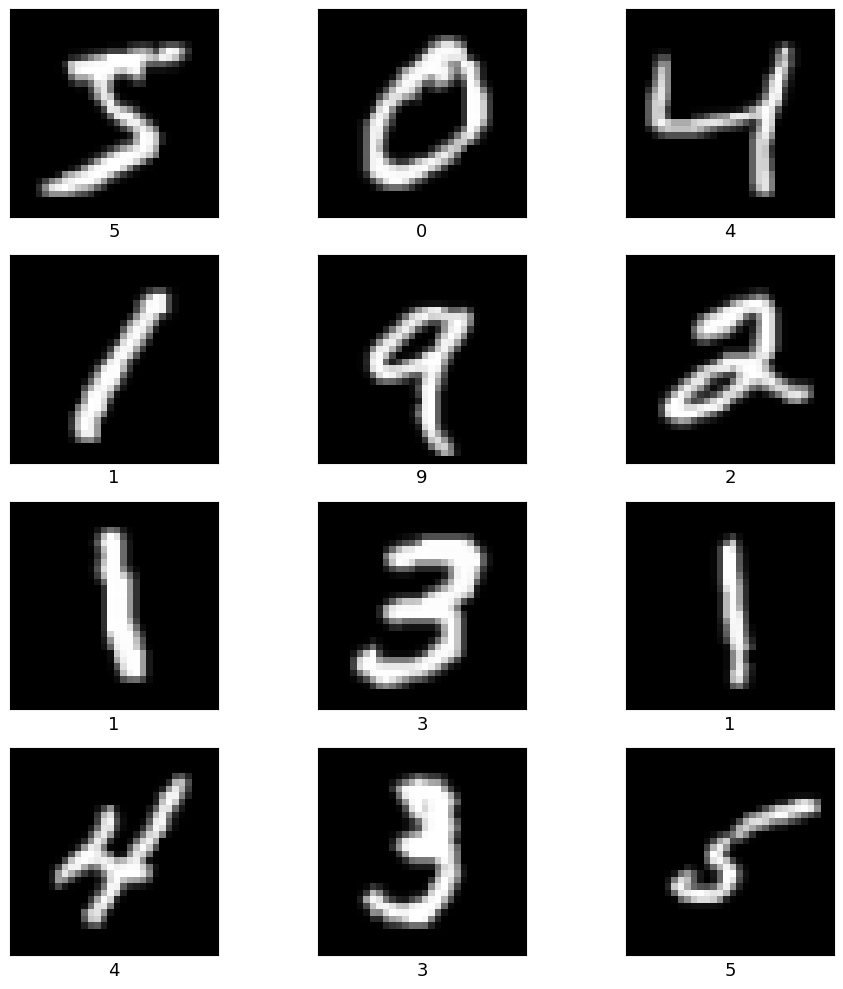

In [7]:
# Visualize the first 12 training images (after resizing)
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im_resized[i].numpy().squeeze(), cmap='gray')  # Visualize resized images
    plt.xlabel(train_lab[i], fontsize=13)
plt.tight_layout()
plt.show()

In [8]:
# One hot encoding for labels
train_lab_categorical = tf.keras.utils.to_categorical(train_lab, num_classes=10, dtype='uint8')
test_lab_categorical = tf.keras.utils.to_categorical(test_lab, num_classes=10, dtype='uint8')

# Train-test split

In [9]:
# Convert TensorFlow tensors to NumPy arrays
train_im_resized_np = train_im_resized.numpy()
test_im_resized_np = test_im_resized.numpy()

In [10]:
# Train-test split (using a validation set)
from sklearn.model_selection import train_test_split
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im_resized_np, train_lab_categorical, 
                                                            test_size=0.20, stratify=train_lab_categorical, 
                                                            random_state=40, shuffle=True)

In [11]:
print("train data shape after the split: ", train_im.shape)
print("validation data shape: ", valid_im.shape)
print("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (48000, 32, 32, 1)
validation data shape:  (12000, 32, 32, 1)
validation labels shape:  (12000, 10)


# Data Augmentation

In [12]:
# Data augmentation (for training set)
batch_size = 64
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range=0.1, 
                                                                horizontal_flip=True)

# No augmentation for validation set
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [13]:
# Prepare the train and validation sets
train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size)
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size)

# Building the Model

In [14]:
resnet = tf.keras.applications.ResNet50(weights=None, classes=10, input_shape=(32, 32, 1))
resnet.summary()



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                     

# Define learning rate scheduler

In [15]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 8:
        lr *= 0.5e-3
    elif epoch > 6:
        lr *= 1e-3
    elif epoch > 4:
        lr *= 1e-2
    elif epoch > 2:
        lr *= 1e-1
    return lr

lrdecay_callback = tf.keras.callbacks.LearningRateScheduler(lrdecay)

# Define early stopping callback

In [16]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

# Compile the model

In [17]:
resnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# Train the model

In [18]:
resnet_train = resnet.fit(train_set_conv, epochs=10, steps_per_epoch=train_im.shape[0] // batch_size, 
                          validation_steps=valid_im.shape[0] // batch_size, validation_data=valid_set_conv, 
                          callbacks=[lrdecay_callback, earlystop_callback])

Epoch 1/10


750/750 [==============================] - 395s 488ms/step - loss: 0.7882 - accuracy: 0.7752 - val_loss: 0.2820 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 2/10
750/750 [==============================] - 419s 559ms/step - loss: 0.4074 - accuracy: 0.8897 - val_loss: 0.1482 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 3/10
750/750 [==============================] - 378s 504ms/step - loss: 0.2371 - accuracy: 0.9324 - val_loss: 0.3310 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 4/10
750/750 [==============================] - 355s 473ms/step - loss: 0.1364 - accuracy: 0.9609 - val_loss: 0.0653 - val_accuracy: 0.9809 - lr: 1.0000e-04
Epoch 5/10
750/750 [==============================] - 353s 471ms/step - loss: 0.1048 - accuracy: 0.9680 - val_loss: 0.0747 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 6/10
750/750 [==============================] - 342s 455ms/step - loss: 0.0931 - accuracy: 0.9714 - val_loss: 0.0592 - val_accuracy: 0.9821 - lr: 1.0000e-05
Epoch 7/10
750/750 [============

# Plot training and validation curves

C:\Users\Noor\AppData\Local\Temp\ipykernel_23532\3319219203.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-0.3, 100)


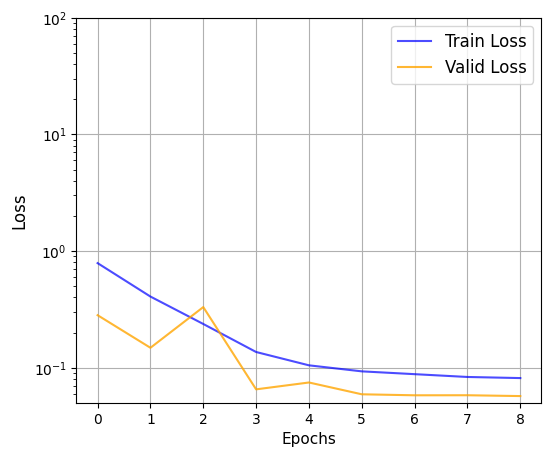

In [31]:
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']
acc = resnet_train.history['accuracy']
v_acc = resnet_train.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(6, 5))
plt.yscale('log')
plt.plot(epochs, loss, color='blue', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, color='orange', alpha=0.8, label='Valid Loss')
plt.ylim(-0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

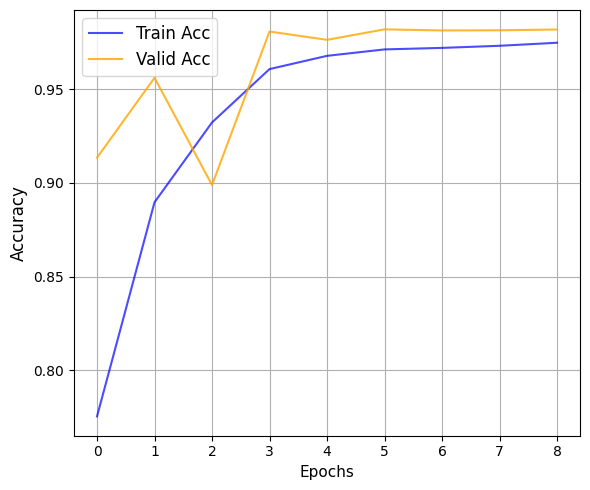

In [30]:
fig = plt.figure(figsize=(6, 5))
plt.plot(epochs, acc, color='blue', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, color='orange', alpha=0.8, label='Valid Acc')
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid()
plt.show()

# Make predictions and plot the confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions):
    ''' Plots confusion matrix and classification report '''
    cm = confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr = classification_report(test_lab, np.argmax(np.round(predictions), axis=1), 
                                target_names=[str(i) for i in range(10)])
    print(cr)
    plt.figure(figsize=(6,4))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[str(i) for i in range(10)], 
                          yticklabels=[str(i) for i in range(10)], fmt="d")
    fig = sns_hmp.get_figure()
    plt.show()

313/313 [==============================] - 22s 70ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       1.00      0.99      1.00      1135
           2       0.97      0.97      0.97      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.97      0.97       892
           6       0.99      0.97      0.98       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



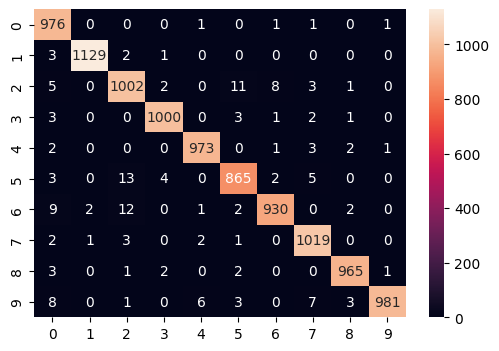

In [33]:
pred_class_resnet50 = resnet.predict(test_im_resized)
conf_matrix(pred_class_resnet50)

# Evaluate on test set

In [23]:
test_result = resnet.evaluate(test_im_resized, test_lab_categorical, verbose=0)
print("ResNet50 test loss: ", test_result[0])
print("ResNet50 test accuracy: ", test_result[1])

ResNet50 test loss:  0.04682634025812149
ResNet50 test accuracy:  0.9847999811172485
